In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 1
I approached the four visualizations by examining four research questions about the data, then attempted to answer them with the visualizations.

### RQ1: Is there such a first-world, second-world, third-world country, with respect to GDP and Gini coefficient?

The existence of a first-world, second-world, and third-world country is predicated on the notion that we may cluster countries together into three distinct groups. For this first visualization, we see if this predication is true. In other words, can countries be neatly clustered into three groups based purely on GDP and Gini coefficient?

In [2]:
df = pd.read_csv('wiid.csv')
filtered = df[(df['quality']=='High') | (df['quality']=='Average')]  # Only get high/average data

Initially, I wanted to filter out data points that were not "high" quality. However, I noticed that this eliminated too many data points. It may also bias the analysis, since countries that have "high" quality data may be more wealthy. We also conduct separate analyses for each 5 year increments. I believe that this is a reasonable increment because of change in productivity due to technology, as well as changes in social policy, etc. 

In [3]:
analyses = []  # each list holds data points for a 5-year analysis
for i in range(filtered.year.min(), filtered.year.max()+1, 5):
    yf = filtered[(filtered.year-5)<i]  # filter data points in five year intervals
    ypoints = []  # store the data points associated with each year
    for country in filtered.country.unique():
        avg_gini = yf[yf.country==country]['gini_reported'].mean()
        avg_gdp = yf[yf.country==country]['gdp_ppp_pc_usd2011'].mean()
        avg_pop = yf[yf.country==country]['population'].mean()
        income_group = yf[yf.country==country]['incomegroup'].mode()
        if pd.isna(avg_gini) or pd.isna(avg_gdp) or pd.isna(avg_pop):  # We do not consider countries that do not have either data point.
            continue
        ypoints.append([avg_gini,avg_gdp,100*avg_pop/yf.population.max(),income_group,country])
    if len(ypoints) == 0:
        continue
    analyses.append([ypoints,i])

Text(0.5, 1.0, 'GDP Per Capita vs. Gini Coefficient')

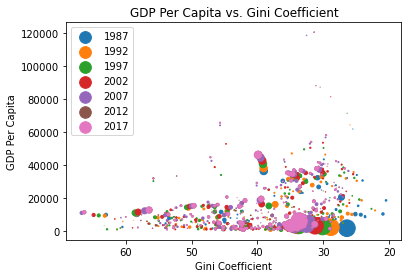

In [4]:
for a,y in analyses:
    plt.scatter([v[0] for v in a],[v[1] for v in a],s=[3*v[2] for v in a],label=y)
    plt.legend()
    plt.gca().invert_xaxis()
plt.xlabel('Gini Coefficient')
plt.ylabel('GDP Per Capita')
plt.title('GDP Per Capita vs. Gini Coefficient')

As we see between various five year peroids, there is little change between the underlying distribution of data points. This in itself probably makes for an interesting analysis on public policy. For some point clusters (which represent the same country), they are crawling toward the top left corner. This may imply that as countries become more "developed" we see higher GDP per capita, but also a higher Gini score (less distribution of wealth). Is this increase in GDP per capita a result of an increase in wealth of all citizens or only those already at the top? This motivates the next question.

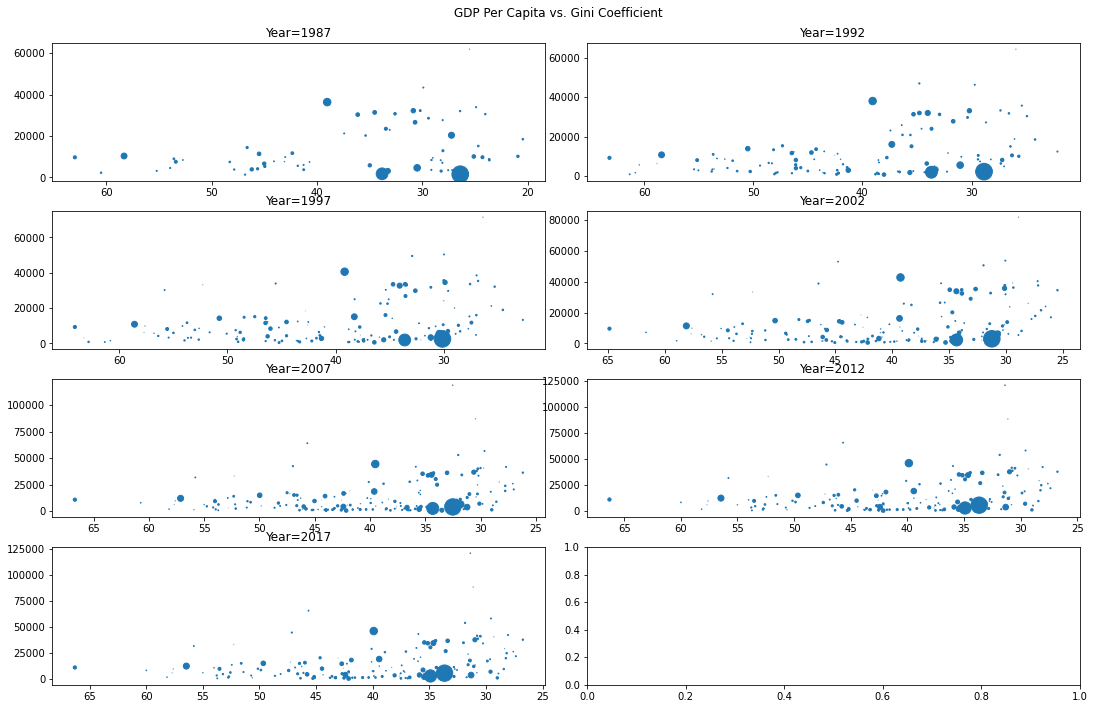

In [5]:
fig,axes = plt.subplots(4,2,figsize=(15,10))
fig.tight_layout()
axes = axes.flatten()
for i,(a,y) in enumerate(analyses):
    axes[i].scatter([v[0] for v in a],[v[1] for v in a],s=[3*v[2] for v in a],)
    axes[i].invert_xaxis()
    axes[i].set_title(f'Year={y}')
fig.suptitle('GDP Per Capita vs. Gini Coefficient')
fig.subplots_adjust(top=0.93)
plt.show()

The points are scaled by relative population. We see that from year to year we cannot make out clear clusters between various countries. We may empircally measure this by running $k$-means clustering such that points are weighted by population, then calculating a silhoutte score. However, in this case it seems trivial. Therefore, we conclude that there is likely no such thing as first-world, second-world, third-world countries w.r.t. gini coefficients and GDP per capita.

### RQ2: What is the general development trajectory (w.r.t. overall wealth and wealth distribution) of "low income", "lower middle income", "upper middle income", and "high income" countries?

In [6]:
df.incomegroup.unique()

array(['Low income', 'Upper middle income', 'High income',
       'Lower middle income'], dtype=object)

In [148]:
analyses = []
for ig in ['Low income', 'Lower middle income','Upper middle income', 'High income', ]:
    igf = df[df.incomegroup == ig]
    incomegroup = []
    for country in igf.country.unique():
        ctr = []
        for i in range(igf.year.min(), igf.year.max()+1,5):
            yfr = igf[(igf.country==country) & (igf.year-5<i)]
            avg_gini = yfr['gini_reported'].mean()
            avg_gdp = yfr['gdp_ppp_pc_usd2011'].mean()
            avg_pop = yfr['population'].mean()
            if pd.isna(avg_gini) or pd.isna(avg_gdp) or pd.isna(avg_pop):
                continue
            ctr.append([avg_gini,avg_gdp,avg_pop])
        incomegroup.append([ctr,country])
    analyses.append(incomegroup)

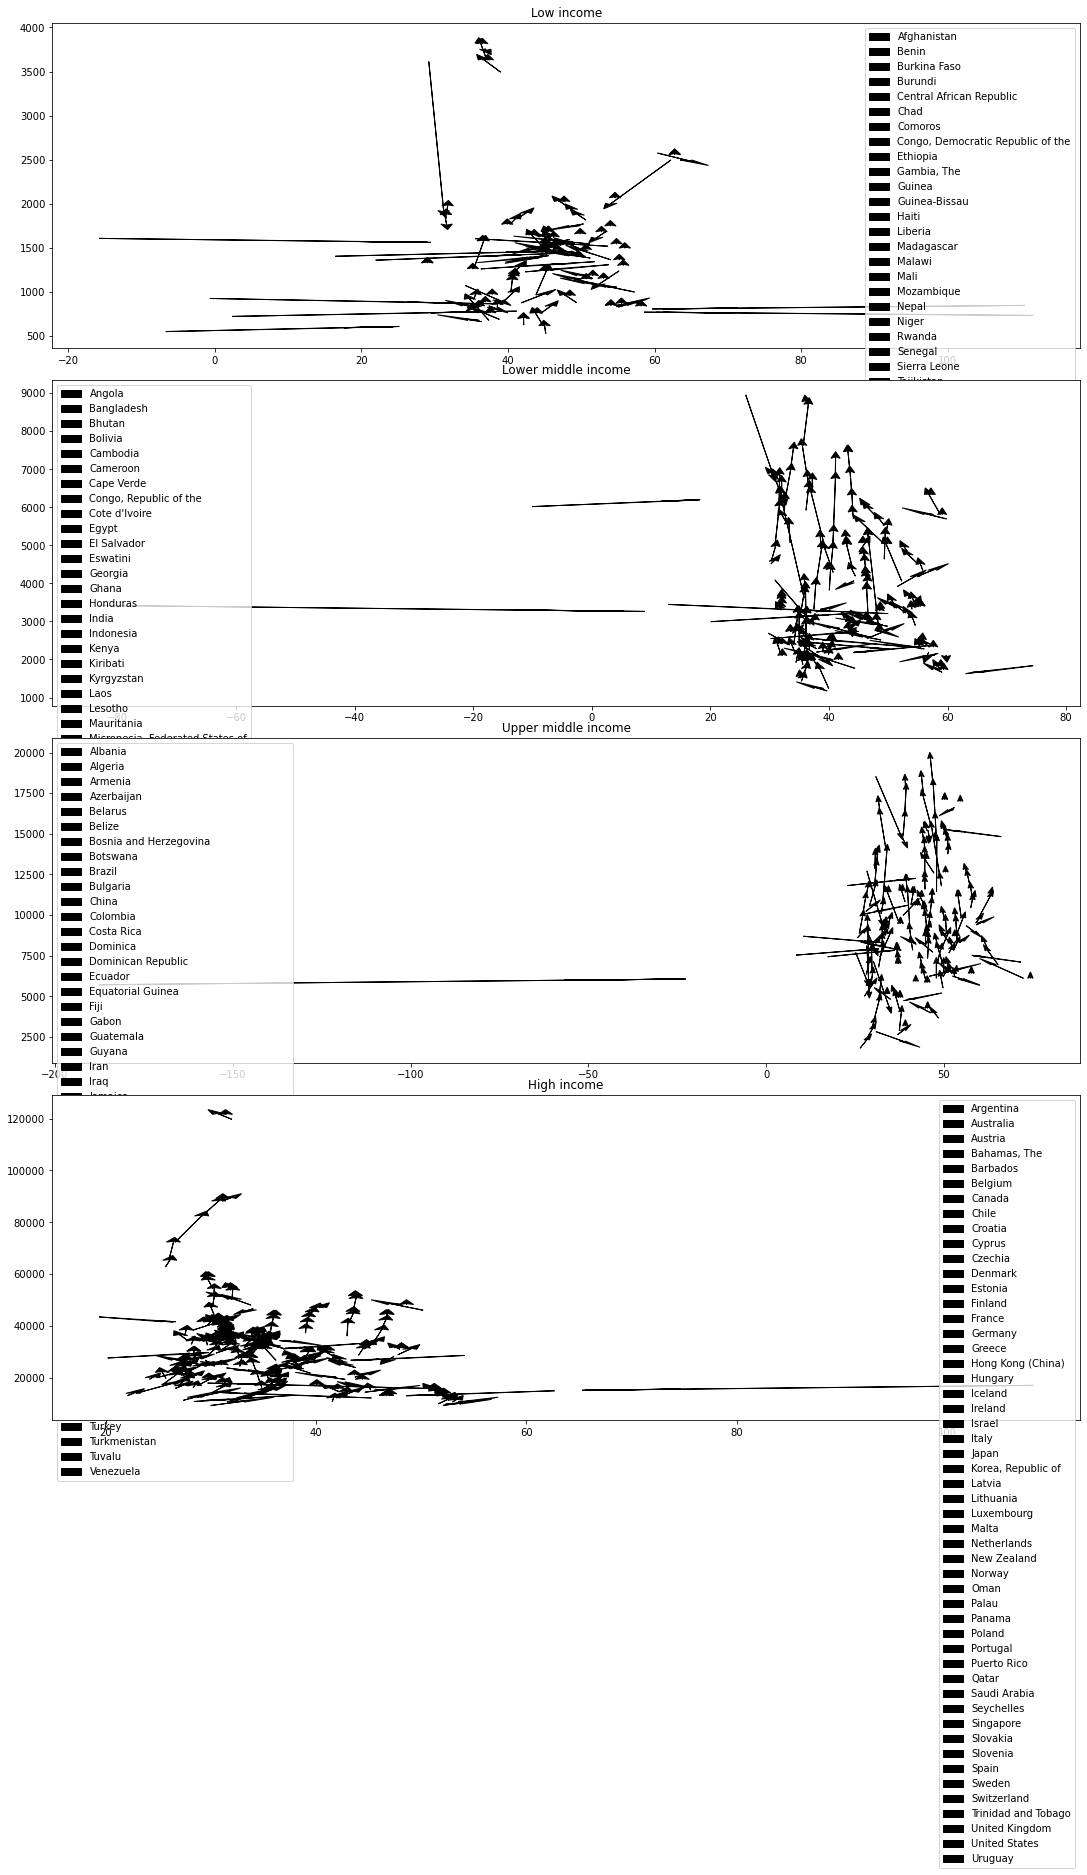

In [182]:
fig,axes = plt.subplots(4,figsize=(15,20))
fig.tight_layout()
for i,ig in enumerate(['Low income', 'Lower middle income','Upper middle income', 'High income']):
    _maxgdp = df[df.incomegroup==ig]['gdp_ppp_pc_usd2011'].max()
    _maxgii = df[df.incomegroup==ig]['gini_reported'].max()
    for data,country in analyses[i]:
        c = []
        if len(data) == 0: continue
        initial = data[0]
        for j, dp in enumerate(data[1:]):
            c.append(axes[i].arrow(initial[0], initial[1],
                          dp[0] - initial[0],dp[1] - initial[1],
                          width=0.01,color="k",head_starts_at_zero=True,label=country if j==0 else "",
                          head_width=_maxgii*0.02, head_length=_maxgdp*0.015,overhang=0.2,))
            initial = data[j+1]
        axes[i].legend()
    axes[i].set_title(ig)
plt.show()